## Trabalho 1

### Bibliotecas

In [297]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Importando o dataset escolhido

Descrição oficial do dataset:
- Blood Transfusion Service Center
- Data taken from the Blood Transfusion Service Center in Hsin-Chu City in Taiwan -- this is a classification problem.

In [298]:
bloodtsc = fetch_openml("blood-transfusion-service-center", version=1, as_frame=False)

df = pd.DataFrame(bloodtsc.data, columns=bloodtsc.feature_names)
df.head()

,V1,V2,V3,V4
0,2,50,12500,98
1,0,13,3250,28
2,1,16,4000,35
3,2,20,5000,45
4,1,24,6000,77


### Informações importantes

In [299]:
print(bloodtsc.DESCR)

**Author**: Prof. I-Cheng Yeh  
**Source**: [UCI](https://archive.ics.uci.edu/ml/datasets/Blood+Transfusion+Service+Center)  
**Please cite**: Yeh, I-Cheng, Yang, King-Jang, and Ting, Tao-Ming, "Knowledge discovery on RFM model using Bernoulli sequence", Expert Systems with Applications, 2008.   

**Blood Transfusion Service Center Data Set**  
Data taken from the Blood Transfusion Service Center in Hsin-Chu City in Taiwan. This is a classification problem.

To demonstrate the RFMTC marketing model (a modified version of RFM), this study adopted the donor database of Blood Transfusion Service Center in Hsin-Chu City in Taiwan. The center passes their blood transfusion service bus to one university in Hsin-Chu City to gather blood donated about every three months. To build an FRMTC model, we selected 748 donors at random from the donor database. 

### Attribute Information  
* V1: Recency - months since last donation
* V2: Frequency - total number of donation
* V3: Monetary - total bloo

### Rename das colunas

In [300]:
df.rename(columns={'V1': 'Recency', 'V2': 'Frequency', 'V3': 'Monetary', 'V4': 'Time'}, inplace=True)
df.head()

,Recency,Frequency,Monetary,Time
0,2,50,12500,98
1,0,13,3250,28
2,1,16,4000,35
3,2,20,5000,45
4,1,24,6000,77


### Target

Com base na descrição oficial:

- '2' significa doou sangue.
- '1' significa não doou sangue.

In [301]:
df['Donated'] = bloodtsc.target
df['Donated'] = df['Donated'].apply(lambda x: 1 if x == '2' else 0)
df.head()

,Recency,Frequency,Monetary,Time,Donated
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


### Informações Relevantes, Amostras e Atributos

In [302]:
print(f'Dimensão: {df.shape}\n'), df.info()

Dimensão: (748, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Recency    748 non-null    int64
 1   Frequency  748 non-null    int64
 2   Monetary   748 non-null    int64
 3   Time       748 non-null    int64
 4   Donated    748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB


(None, None)

### Análise das Classes

In [303]:
df['Donated'].value_counts()

Donated
0    570
1    178
Name: count, dtype: int64

A classe é desbalanceada

### Nulos e Duplicados

In [304]:
print(f'Nulos por coluna:\n{df.isnull().sum()}')
print(f'\nLinhas Duplicadas: {df.duplicated().sum()}')

Nulos por coluna:
Recency      0
Frequency    0
Monetary     0
Time         0
Donated      0
dtype: int64

Linhas Duplicadas: 215


Muitas linhas repetidas, é necessário apagar as duplicatas

### Identificação de Outliers 

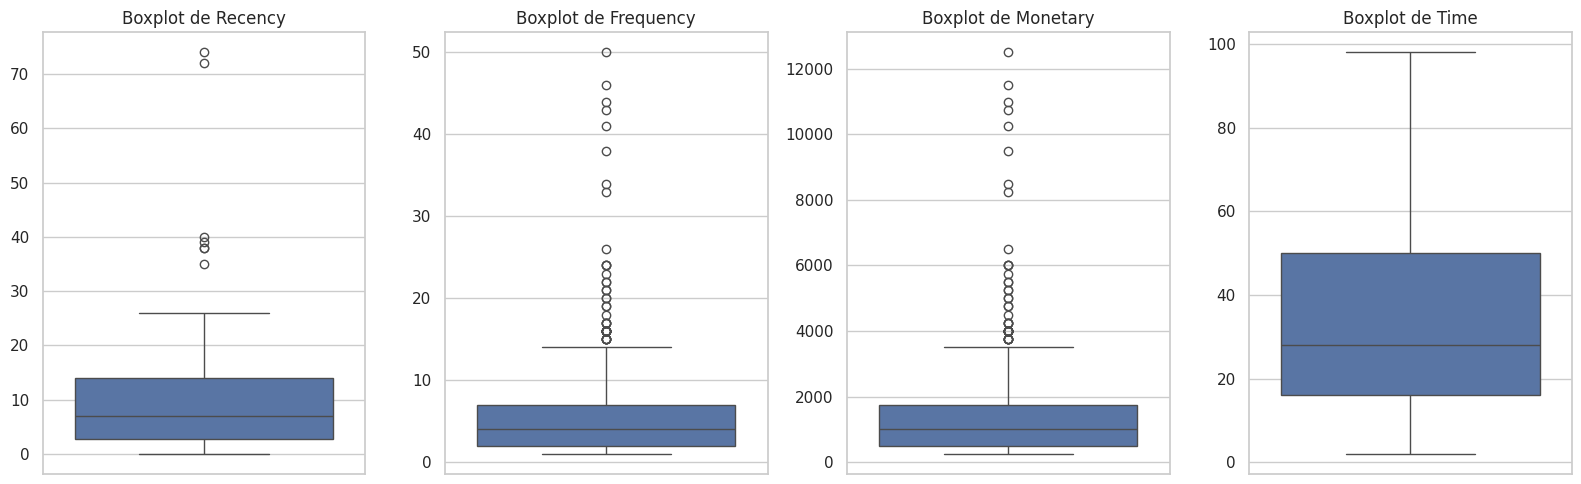

In [305]:
feature_columns = df.columns

plt.figure(figsize=(20, 5))
for i, column in enumerate(feature_columns[:4]):
    plt.subplot(1, len(feature_columns), i + 1)
    sns.boxplot(y=df[column])
    plt.title(f'Boxplot de {column}')
    plt.ylabel('')

plt.tight_layout()
plt.show()

É notável a existência de outliers

### Análise dos Dados Brutos

Obter média, desvio padrão, mínimo, máximo e quartis

In [306]:
df_features = df[feature_columns[:4]]

data_description = df_features.describe()
print("Estatísticas Descritivas (Média, Desvio Padrão, Mín/Máx)")
print(data_description)

Estatísticas Descritivas (Média, Desvio Padrão, Mín/Máx)
          Recency   Frequency      Monetary        Time
count  748.000000  748.000000    748.000000  748.000000
mean     9.506684    5.514706   1378.676471   34.282086
std      8.095396    5.839307   1459.826781   24.376714
min      0.000000    1.000000    250.000000    2.000000
25%      2.750000    2.000000    500.000000   16.000000
50%      7.000000    4.000000   1000.000000   28.000000
75%     14.000000    7.000000   1750.000000   50.000000
max     74.000000   50.000000  12500.000000   98.000000


Calcular a variância para cada atributo

In [307]:
data_variance = df_features.var()
print("Variância de cada Atributo")
print(data_variance)

Variância de cada Atributo
Recency      6.553543e+01
Frequency    3.409751e+01
Monetary     2.131094e+06
Time         5.942242e+02
dtype: float64


Calcular e visualizar a matriz de correlação

Matriz de Correlação
            Recency  Frequency  Monetary      Time
Recency    1.000000  -0.182745 -0.182745  0.160618
Frequency -0.182745   1.000000  1.000000  0.634940
Monetary  -0.182745   1.000000  1.000000  0.634940
Time       0.160618   0.634940  0.634940  1.000000


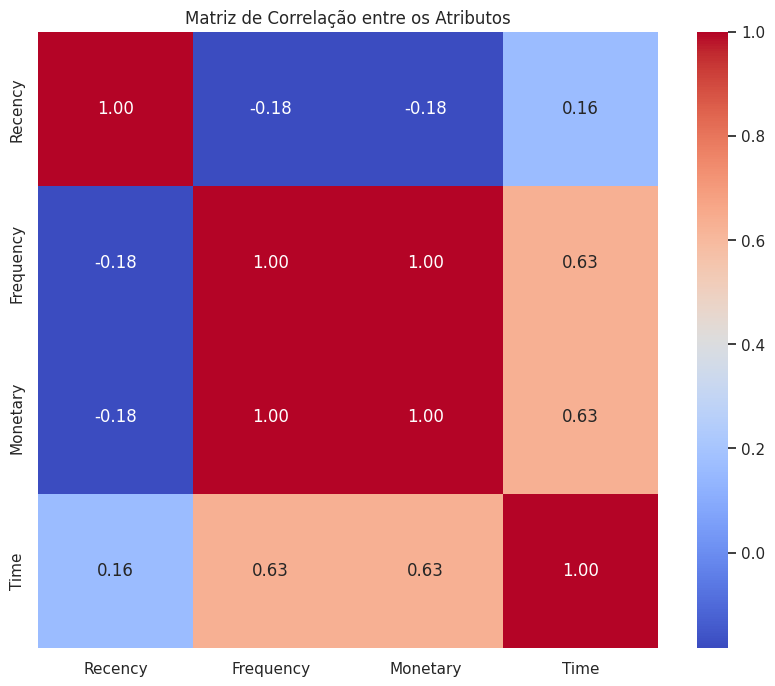

In [308]:
correlation_matrix = df_features.corr()
print("Matriz de Correlação")
print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação entre os Atributos')
plt.show()

### Remoção das linhas duplicadas

In [309]:
df.drop_duplicates(inplace=True)

print(f'Nova dimensão da tabela: {df.shape}')
print(f'\nLinhas Duplicadas: {df.duplicated().sum()}')

Nova dimensão da tabela: (533, 5)

Linhas Duplicadas: 0


### Análise PCA

Padronização dos dados

In [310]:
X = df[feature_columns[:4]]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

PCA com 3 componentes

In [311]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

In [312]:
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3'], index=feature_columns[:4])
print("Influência (loadings) de cada atributo nas componentes principais:")
print(loadings)

explained_variance = pca.explained_variance_ratio_
print(f"\nVariância explicada por PC1: {explained_variance[0]:.2%}")
print(f"Variância explicada por PC2: {explained_variance[1]:.2%}")
print(f"Variância explicada por PC3: {explained_variance[2]:.2%}")
print(f"Variância total explicada pelas 3 componentes: {np.sum(explained_variance):.2%}")

Influência (loadings) de cada atributo nas componentes principais:
                PC1       PC2       PC3
Recency   -0.135455  0.886367 -0.442726
Frequency  0.620589 -0.070722 -0.331464
Monetary   0.620589 -0.070722 -0.331464
Time       0.459773  0.452052  0.764367

Variância explicada por PC1: 61.45%
Variância explicada por PC2: 27.67%
Variância explicada por PC3: 10.88%
Variância total explicada pelas 3 componentes: 100.00%


### Seleção de Características

Seleção com base no SelectKBest

In [313]:
X = df[feature_columns[:4]]
y = df['Donated']

selector = SelectKBest(score_func=f_classif, k=3)

X_new = selector.fit_transform(X, y)

Informações sobre a seleção

In [314]:
scores = selector.scores_
feature_scores = pd.DataFrame({'Atributo': feature_columns[:4], 'Score': scores})
print("Pontuação de cada atributo (ANOVA F-test):")
print(feature_scores.sort_values(by='Score', ascending=False))

selected_features = X.columns[selector.get_support()]
print(f"\nOs 3 atributos selecionados são: {list(selected_features)}")

df_selected_kbest = df[list(selected_features)]

print("\nDataFrame após seleção com SelectKBest:")
print(df_selected_kbest.head())

Pontuação de cada atributo (ANOVA F-test):
    Atributo      Score
0    Recency  43.373555
1  Frequency  16.690665
2   Monetary  16.690665
3       Time   9.743798

Os 3 atributos selecionados são: ['Recency', 'Frequency', 'Monetary']

DataFrame após seleção com SelectKBest:
   Recency  Frequency  Monetary
0        2         50     12500
1        0         13      3250
2        1         16      4000
3        2         20      5000
4        1         24      6000


### Agrupamento (Agglomerative Clustering)

Na base original

In [315]:
X = df[feature_columns[:4]]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

results = {}
range_n_clusters = range(2, 11) 

print("Análise na Base de Dados Original")
for n in range_n_clusters:
    clusterer = AgglomerativeClustering(n_clusters=n, linkage='ward')
    labels = clusterer.fit_predict(X_scaled)
    
    db_score = davies_bouldin_score(X_scaled, labels)
    results[n] = db_score
    print(f"Para n_clusters = {n}, o score Davies-Bouldin é {db_score:.4f}")

best_n = min(results, key=results.get)
best_score = results[best_n]

print(f"\nMelhor resultado para a base original:")
print(f"Número ótimo de clusters: {best_n}")
print(f"Menor score Davies-Bouldin: {best_score:.4f}")

clusterer_final_original = AgglomerativeClustering(n_clusters=best_n, linkage='ward')
df['cluster_original'] = clusterer_final_original.fit_predict(X_scaled)


Análise na Base de Dados Original
Para n_clusters = 2, o score Davies-Bouldin é 0.9104
Para n_clusters = 3, o score Davies-Bouldin é 1.2188
Para n_clusters = 4, o score Davies-Bouldin é 1.0226
Para n_clusters = 5, o score Davies-Bouldin é 0.9862
Para n_clusters = 6, o score Davies-Bouldin é 1.1053
Para n_clusters = 7, o score Davies-Bouldin é 0.9628
Para n_clusters = 8, o score Davies-Bouldin é 0.9358
Para n_clusters = 9, o score Davies-Bouldin é 0.9119
Para n_clusters = 10, o score Davies-Bouldin é 0.8748

Melhor resultado para a base original:
Número ótimo de clusters: 10
Menor score Davies-Bouldin: 0.8748


In [316]:
X_selected = df_selected_kbest

scaler = StandardScaler()
X_selected_scaled = scaler.fit_transform(X_selected)

results_selected = {}

print("\nAnálise na Base com Características Selecionadas")
for n in range_n_clusters:
    clusterer_sel = AgglomerativeClustering(n_clusters=n, linkage='ward')
    labels_sel = clusterer_sel.fit_predict(X_selected_scaled)
    db_score_sel = davies_bouldin_score(X_selected_scaled, labels_sel)
    results_selected[n] = db_score_sel
    print(f"Para n_clusters = {n}, o score Davies-Bouldin é {db_score_sel:.4f}")

best_n_sel = min(results_selected, key=results_selected.get)
best_score_sel = results_selected[best_n_sel]

print(f"\nMelhor resultado para a base com características selecionadas:")
print(f"Número ótimo de clusters: {best_n_sel}")
print(f"Menor score Davies-Bouldin: {best_score_sel:.4f}")

clusterer_final_sel = AgglomerativeClustering(n_clusters=best_n_sel, linkage='ward')
df['cluster_selected'] = clusterer_final_sel.fit_predict(X_selected_scaled)


Análise na Base com Características Selecionadas
Para n_clusters = 2, o score Davies-Bouldin é 0.9980
Para n_clusters = 3, o score Davies-Bouldin é 0.7762
Para n_clusters = 4, o score Davies-Bouldin é 0.6582
Para n_clusters = 5, o score Davies-Bouldin é 0.5457
Para n_clusters = 6, o score Davies-Bouldin é 0.6688
Para n_clusters = 7, o score Davies-Bouldin é 0.6968
Para n_clusters = 8, o score Davies-Bouldin é 0.6513
Para n_clusters = 9, o score Davies-Bouldin é 0.6731
Para n_clusters = 10, o score Davies-Bouldin é 0.7037

Melhor resultado para a base com características selecionadas:
Número ótimo de clusters: 5
Menor score Davies-Bouldin: 0.5457


### PCA base original

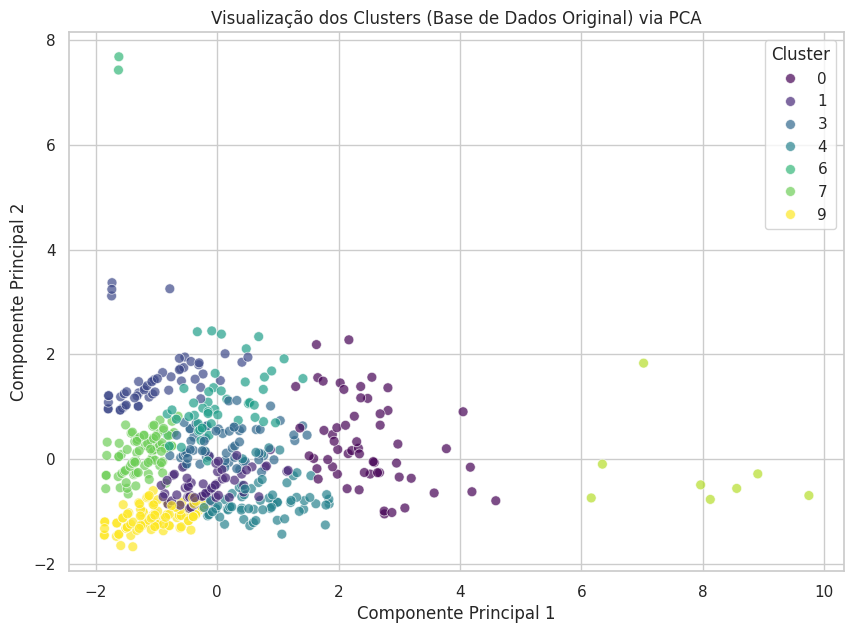

In [317]:
pca_original = PCA(n_components=2)
X_original_pca = pca_original.fit_transform(X_scaled)

# 2. Criar um DataFrame para a visualização
df_pca_original = pd.DataFrame(
    data=X_original_pca, 
    columns=['Componente Principal 1', 'Componente Principal 2']
)
# Adicionar a coluna de cluster. Usamos .values para garantir o alinhamento.
df_pca_original['Cluster'] = df['cluster_original'].values

# 3. Criar o gráfico de dispersão
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='Componente Principal 1', 
    y='Componente Principal 2',
    hue='Cluster',
    data=df_pca_original,
    palette='viridis', # Você pode escolher outras paletas de cores
    s=50, # Tamanho dos pontos
    alpha=0.7
)

plt.title('Visualização dos Clusters (Base de Dados Original) via PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

### PCA base modificada

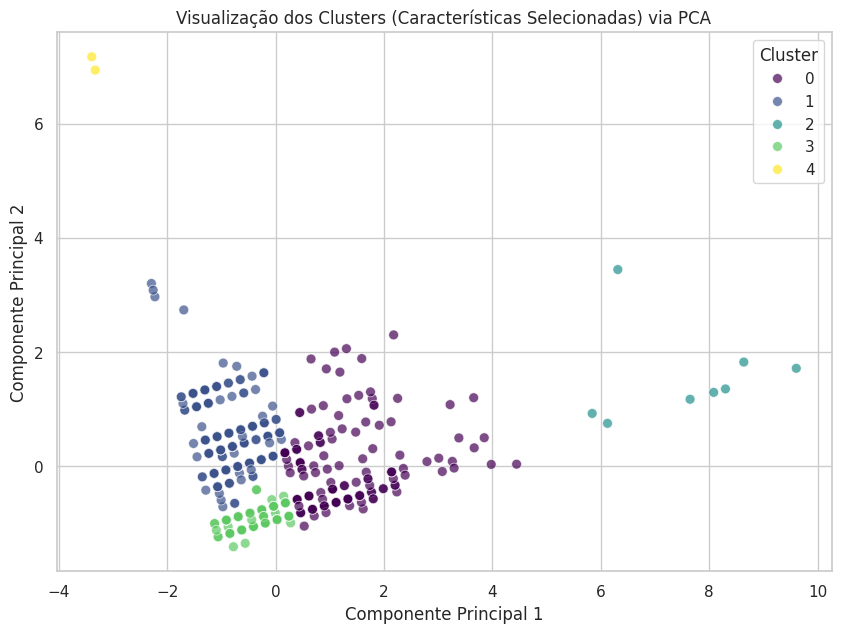

In [318]:
pca_selected = PCA(n_components=2)
X_selected_pca = pca_selected.fit_transform(X_selected_scaled)

df_pca_selected = pd.DataFrame(
    data=X_selected_pca, 
    columns=['Componente Principal 1', 'Componente Principal 2']
)
df_pca_selected['Cluster'] = df['cluster_selected'].values

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='Componente Principal 1', 
    y='Componente Principal 2',
    hue='Cluster',
    data=df_pca_selected,
    palette='viridis',
    s=50,
    alpha=0.7
)

plt.title('Visualização dos Clusters (Características Selecionadas) via PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()